<img src="http://nci.org.au/wp-content/themes/nci/img/img-logo-large.png", width=400>

-------
### In this notebook:
-------
- How to use the Python GDAL extensions to open NetCDF files.
- How to reproject datasets between different coordinate systems.
- How to combine and merge data from different sources.
-------
- <a href='#part0'>Required libraries</a>
- <a href='#part1'>Himawari Data</a>
- <a href='#part2'>Intro to the GDAL library</a>
- <a href='#part3'>Digital Elevation model</a>
- <a href='#part4'>Data Fusion</a>
- <a href='#part5'>Practice these concepts</a>

# Canberra, the mountains or the south coast? Where's the best weather?

My aunt lives in Narooma, my brother is in Thredbo and I live in Canberra. Last September we interchanged lots of messages in which we were complaining about the weather in our respective places... But, where was the weather the worst? Let's see if we can find out...

<a id='part0'></a>
## 0.- To run this notebook on the VDI you'll need to first run:

```
$ module purge

$ module load proj/4.8.0 python/3.5.2 python/3.5.2-matplotlib numpy/1.11.1-py3.5 gdal-python/1.11.1-py3.5 ipython/4.2.0-py3.5

$ jupyter notebook

```

<a id='part1'></a>
## 1.- Intro to Himawari8
Himawari 8 is a geostationary satellite that covers the area of the Asia-Pacific and takes a new picture every 10 minutes.

The Bureau of Meteorology uses this information operationally for their weather forecasts and the historical data is stored at the NCI at: /g/data2/rr5/satellite/obs/himawari8/FLDK/

### 1.1.- An index for Himawari8 files

In [1]:
import datetime
import os.path

def himawari8_path(UTC_datetime, band):
    base = "/g/data2/rr5/satellite/obs/himawari8/FLDK/{year:d}/{month:02d}/{day:02d}/{hour:02d}{minute:02d}/"
    file_name = "{year:d}{month:02d}{day:02d}{hour:02d}{minute:02d}00-P1S-ABOM_BRF_B{band:02d}-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc"

    st = datetime.datetime.strptime(UTC_datetime, "%Y%m%d%H%M")

    path = (base.format(year=st.year, month=st.month, day=st.day, hour=st.hour, minute=st.minute) +
            file_name.format(year=st.year, month=st.month, day=st.day, hour=st.hour, minute=st.minute, band=band))

    if not os.path.isfile(path):
        return None
    
    return path

# For example, to get the path to band 1 taken of the 25th Dec 2015 at 00:00 UTC
himawari8_path("201512250000", 1)

'/g/data2/rr5/satellite/obs/himawari8/FLDK/2015/12/25/0000/20151225000000-P1S-ABOM_BRF_B01-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'

### 1.2.- Plot raw data from a Himawari8 file

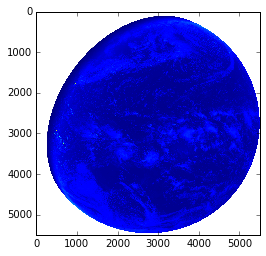

In [2]:
%matplotlib inline

from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

ds = gdal.Open(himawari8_path("201512250000", 1))
band1 = ds.GetRasterBand(1)
raster = band1.ReadAsArray()
no_data = band1.GetNoDataValue()
    
masked = np.ma.array(raster, mask=(raster==no_data))
plt.imshow(masked)


### 1.3.- Create a RGB composite using three bands

(5500, 5500, 3)


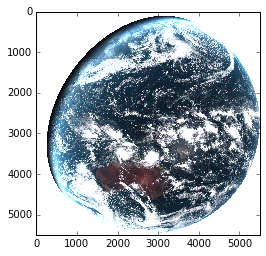

In [3]:
def him_rgb(UTC_datetime, rgb_bands, clip):
    red_path = himawari8_path(UTC_datetime, rgb_bands[0])
    ds_r = gdal.Open(red_path)
    red = ds_r.GetRasterBand(1).ReadAsArray()
    red = (red.clip(0, clip) / clip * 255).astype(np.uint8)

    green_path = himawari8_path(UTC_datetime, rgb_bands[1])
    ds_g = gdal.Open(green_path)
    green = ds_g.GetRasterBand(1).ReadAsArray()
    green = (green.clip(0, clip) / clip * 255).astype(np.uint8)

    blue_path = himawari8_path(UTC_datetime, rgb_bands[2])
    ds_b = gdal.Open(blue_path)
    blue = ds_b.GetRasterBand(1).ReadAsArray()
    blue = (blue.clip(0, clip) / clip * 255).astype(np.uint8)

    return np.stack((red, green, blue), axis=2)

rgb = him_rgb("201512250000", [3, 2, 1], .65)
print(rgb.shape)
plt.imshow(rgb)

### 1.4.- Plotting a portion of the image

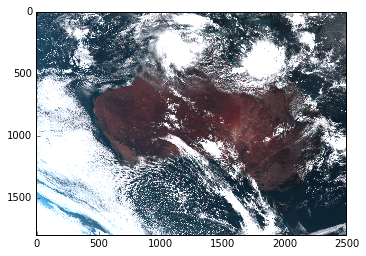

In [4]:
plt.imshow(rgb[3200:5000, 1000:3500, :])

<a id='part2'></a>
## 2.- Intro to GDAL: Different datasets cover different areas with different projections and resolutions...
### How can we combine data coming from different sources?

### 2.1.- Defining a region in GeoJSON
[geojson.io](http://geojson.io)

This website allows us to draw polygons and get their gjson representation. For example:

'{"type":"Polygon","coordinates":[[[148.5,-36],[148.5,-35],[150.2,-35],[150.2,-36],[148.5,-36]]]}'

Represents a box covering the Canberra region.

![caption](./images/notebook_geojson.png)

### 2.2.- Defining a canvas raster in GDAL: Extent, Size and Projection

In [5]:
import json

wgs84_wkt ='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

def get_raster(geojson_poly, pix_size):
    coords = json.loads(geojson_poly)["coordinates"]
    
    min_lat = min(coords[0][1][1], coords[0][0][1])
    max_lat = max(coords[0][1][1], coords[0][0][1])
    
    min_lon = min(coords[0][2][0], coords[0][0][0])
    max_lon = max(coords[0][2][0], coords[0][0][0])
    
    geotrans = [min_lon, pix_size, 0.0, max_lat, 0.0, -1.0*pix_size]
    size_x = int((max_lon - min_lon) / pix_size)
    size_y = int((max_lat - min_lat) / pix_size)

    mem_drv = gdal.GetDriverByName('MEM')
    ds = mem_drv.Create('', size_x, size_y, 1, gdal.GDT_Float32)
    ds.SetProjection(wgs84_wkt)
    ds.SetGeoTransform(geotrans)

    return ds

### 2.3.- Reprojecting between reference systems.

In [6]:
def reproject(src_file, dst_ds):
    src_ds = gdal.Open(src_file)
    gdal.ReprojectImage(src_ds, dst_ds, src_ds.GetProjection(), dst_ds.GetProjection(), gdal.GRA_NearestNeighbour)

    return dst_ds.GetRasterBand(1).ReadAsArray()

### 2.3.- Displaying Himawari 8 for a geoJSON defined area.

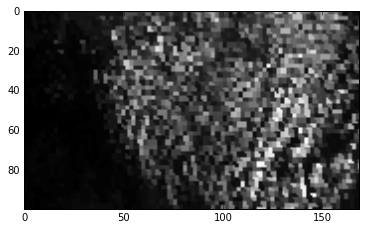

In [7]:
canberra_gjson = '{"type":"Polygon","coordinates":[[[148.5,-36],[148.5,-35],[150.2,-35],[150.2,-36],[148.5,-36]]]}'
him_dest = get_raster(canberra_gjson, .01)
him_proj = reproject(himawari8_path("201512250000", 1), him_dest)

plt.imshow(him_proj, cmap="gray")

### 2.4.- A most probably too simplistic way of getting cloud coverage...

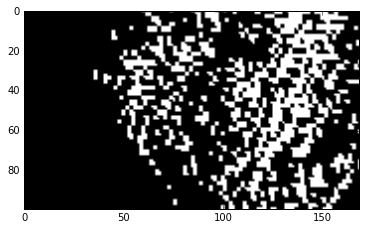

In [8]:
clouds_proj = him_proj > .30
plt.imshow(clouds_proj, cmap="gray")

### 2.5.- What is the mean cloud coverage for that image?

In [9]:
clouds_proj.mean()

0.22372781065088757

<a id='part3'></a>
## 3.- Intro to Digital Elevation Model (DEM) data
DEM models produce regular grid in which each grid point represents a point in a surface and contains the altitude of that location.

Geoscience Australia publishes DEM data for Australia with a precission of a seconds of degree (30 meters). This data is stored at the NCI at: /g/data1/rr1/Elevation/

### 3.1.- Using the above functions to subset these data into the same defined region, resolution and reference system.

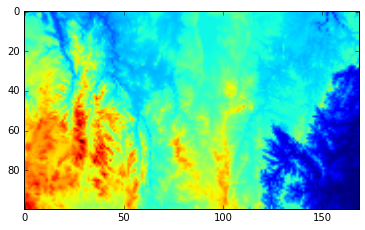

In [10]:
dem_file = "/g/data1/rr1/Elevation/NetCDF/1secSRTM_DEMs_v1.0/DEM-S/Elevation_1secSRTM_DEMs_v1.0_DEM-S_Mosaic_dems1sv1_0.nc"

elv_dest = get_raster(canberra_gjson, .01)
elv_proj = reproject(dem_file, elv_dest)

plt.imshow(elv_proj)

### 3.2.- An altitude profile of our selected region:

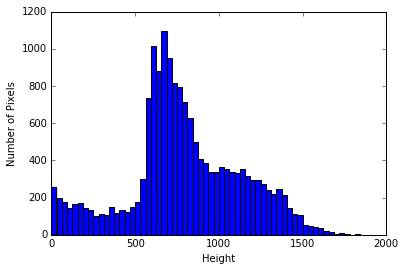

In [11]:
plt.hist(elv_proj.ravel(), bins=64, range=(0.0, 2000))
plt.xlabel('Height')
plt.ylabel('Number of Pixels')
plt.show()

### 3.3.- Defining our regions of interest:

In [12]:
elv_canberra = elv_proj[10:50, 70:120]
elv_mountains = elv_proj[50:, :60]
elv_coast = elv_proj[50:, 130:]

print("The average height in Canberra is {0:.2f} m.".format(elv_canberra.mean()))
print("The average height in the mountains is {0:.2f} m.".format(elv_mountains.mean()))
print("The average height in the coast is {0:.2f} m.".format(elv_coast.mean()))

The average height in Canberra is 776.15 m.
The average height in the mountains is 1245.20 m.
The average height in the coast is 265.97 m.


<a id='part4'></a>
## 4.- Back to out original question: Where is the best weather?

### 4.1.- Packing cloud coverage in a function

In [13]:
def give_me_cloud_coverage(utc_datetime, raster_dest):

    him_proj = reproject(himawari8_path(utc_datetime, 1), raster_dest)
    clouds_proj = him_proj > .30
    clouds_canberra = clouds_proj[10:50, 70:120]
    clouds_mountains = clouds_proj[50:, :60]
    clouds_coast = clouds_proj[50:, 130:]

    return int(clouds_canberra.mean()*100), int(clouds_mountains.mean()*100), int(clouds_coast.mean()*100)

cbr, mtn, cst = give_me_cloud_coverage("201609010000", him_dest)

print("Cloud cover 1st Sept 2016. Canberra: {0:d}% Mountains: {1:d}% Coast: {2:d}%".format(cbr, mtn, cst))

Cloud cover 1st Sept 2016. Canberra: 5% Mountains: 52% Coast: 0%


### 4.2.- Collecting cloud data over a period

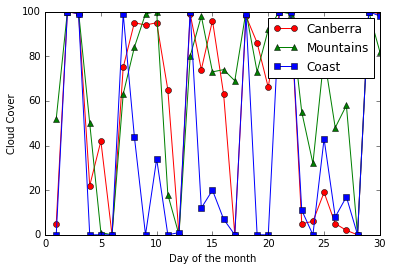

In [15]:
def clouds_in_a_period(UTC_start, UTC_end, raster_dest):
    start = datetime.datetime.strptime(UTC_start, "%Y%m%d%H%M")
    end = datetime.datetime.strptime(UTC_end, "%Y%m%d%H%M")
    
    cbr_list = []
    mtn_list = []
    cst_list = []
    while start <= end:
        cbr, mtn, cst = give_me_cloud_coverage(start.strftime("%Y%m%d%H%M"), raster_dest)
        cbr_list.append(cbr)
        mtn_list.append(mtn)
        cst_list.append(cst)
        start = start + datetime.timedelta(hours=24)

    return cbr_list, mtn_list, cst_list

cbr_month, mtn_month, cst_month = clouds_in_a_period("201609010000", "201609300000", him_dest)
days = np.arange(1, 31, 1)
plt.plot(days, cbr_month, 'ro-', days, mtn_month, 'g^-', days, cst_month, 'bs-', label=["a", "b", "c"])
plt.xlabel('Day of the month')
plt.ylabel('Cloud Cover')
lgnd = ['Canberra', 'Mountains', 'Coast']
plt.legend(lgnd)
plt.show()

### 4.3.- The veredict

In [16]:
print("Canberra had an average {0:d}% of clouds during September 2016.".format(int(np.array(cbr_month).mean())))
print("The mountains had and average {0:d}% of clouds during September 2016.".format(int(np.array(mtn_month).mean())))
print("The coast had and average {0:d}% of clouds during September 2016.".format(int(np.array(cst_month).mean())))

Canberra had an average 57% of clouds during September 2016.
The mountains had and average 66% of clouds during September 2016.
The coast had and average 36% of clouds during September 2016.


## It looks like the coast was the place to be. 

<a id='part5'></a>
## 5.- Have some extra time?
### Try to solve this other question: Last September was very rainy with floods over different parts of NSW. By defining two polygons one for north NSW and other for south NSW can you determine which one had more clouds for that month? 